In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from matplotlib import rc
from scipy.integrate import odeint
from sklearn.metrics import mean_squared_error
%matplotlib inline

## Introduction:
There are generally two different types of model used to forcast and track the spread of a viral disease. One is epidimiology models, such as a compartmentalized SIR model; the other type is machine learning model family, which is mainly data driven.

In this IPython notebook, I will be using a combination of those two types of models. Specifically, I will construct an **SEIRD** (Susceptible, Exposed, Infected, Recovered, Deceased) Compartamentalized model and use data to estimate the parameters in the model. The algorithm I will be using to optimize is **Metropolis-Hastings**, a Markov Chain Monte Carlo **(MCMC)** based method.

## Synopsis:
### 1. Datasets
### 2. Cleaning
### 3. Assumptions
### 4. Model
### 5. Optimization
### 6. Result
### 7. Comments
### 8. Answers to Questions
### 9. Disclaimer

## 1. Datasets

Here is the list of datasets I used:
- state_wise_daily_delhi_gujurat_maharashtra_tamil_nadu_may_15_2020 - state_wise_daily_mh_gj_dl_tn.csv
- StatewiseTestingDetails.csv
- patient_city_district_wise_data_may_5_date_formatted.csv
- state_population_india_census2011.csv

In [364]:
## read in dataframes
status_df = pd.read_csv('state_wise_daily_delhi_gujurat_maharashtra_tamil_nadu_may_15_2020 - state_wise_daily_mh_gj_dl_tn.csv')
testing_df = pd.read_csv('additional_data/StatewiseTestingDetails.csv')
patient_df = pd.read_csv('patient_city_district_wise_data_may_5_date_formatted.csv')
population_df = pd.read_csv('additional_data/state_population_india_census2011.csv')

## 2. Cleaning:
In this section, I will preprocess the datasets, impute missing values, and compute some values for later use.

Let's first look at the dataframe with patients' status:

In [365]:
status_df.head()

,Date,Status,Delhi,Gujurat,Maharashtra,Tamil Nadu
0,14-Mar-20,Confirmed,7,0,14,1
1,14-Mar-20,Recovered,1,0,0,0
2,14-Mar-20,Deceased,1,0,0,0
3,15-Mar-20,Confirmed,0,0,18,0
4,15-Mar-20,Recovered,1,0,0,0


In [366]:
status_df.isnull().any()

Date           False
Status         False
Delhi          False
Gujurat        False
Maharashtra    False
Tamil Nadu     False
dtype: bool

There are no missing values :) There are only data available for 4 of the states. Let's combine them:

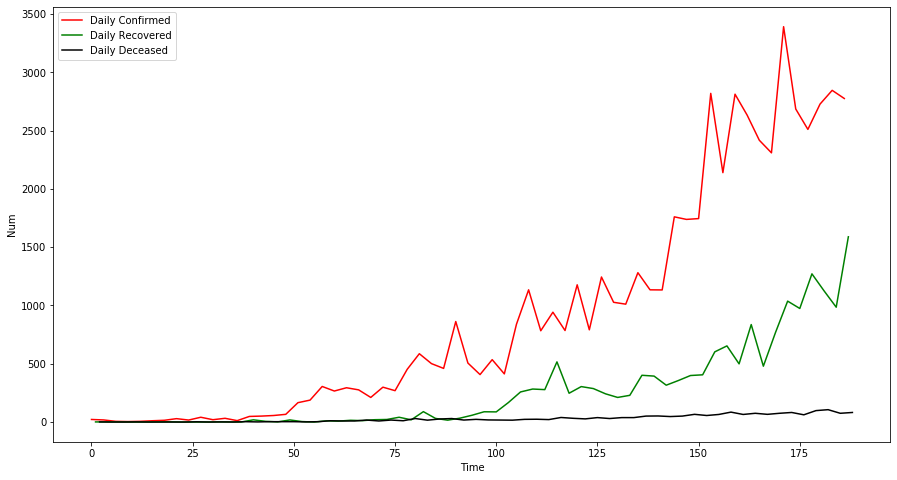

In [367]:
status_df['Country'] = status_df['Delhi'] + status_df['Gujurat'] + status_df['Maharashtra'] + status_df['Tamil Nadu']
all_df = status_df.drop(['Delhi', 'Gujurat', 'Maharashtra', 'Tamil Nadu'], axis=1)
confirmed_df = all_df[all_df['Status'] == 'Confirmed']
recovered_df = all_df[all_df['Status'] == 'Recovered']
deceased_df = all_df[all_df['Status'] == 'Deceased']

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)
ax.plot(confirmed_df['Country'], 'red', label = 'Daily Confirmed')
ax.plot(recovered_df['Country'], 'green', label = 'Daily Recovered')
ax.plot(deceased_df['Country'], 'black', label = 'Daily Deceased')
ax.set_xlabel('Time')
ax.set_ylabel('Num')
legend = ax.legend()

The daily number of confirmed cases looked pretty random, but follows an upward trend, more and more people are getting infected still!

Let's now look at the statewise testing data:

In [368]:
testing_df.head()

,Date,State,TotalSamples,Negative,Positive
0,2020-04-17,Andaman and Nicobar Islands,1403.0,1210.0,12.0
1,2020-04-24,Andaman and Nicobar Islands,2679.0,NaN,27.0
2,2020-04-27,Andaman and Nicobar Islands,2848.0,NaN,33.0
3,2020-05-01,Andaman and Nicobar Islands,3754.0,NaN,33.0
4,2020-04-02,Andhra Pradesh,1800.0,1175.0,132.0


In [369]:
testing_df.isnull().any()

Date            False
State           False
TotalSamples    False
Negative         True
Positive         True
dtype: bool

Columns 'Positive' and 'Negative' have missing values :( However, we could easily impute these values. Notice that we have a complete 'TotalSamples', if we know either 'Positive' or 'Negative', we could estimate the other. But 'Positive' and 'Negative' sometimes do not sum up exactly to 'TotalSamples', might be because some tests are discarded. For simplicity, let's just assume they sum up to 'TotalSamples'.

For the rows that are missing both 'Positive' and 'Negative' values, we use the mean positive testing ratio to calculate the 'Positive' and 'Negative' respectively:

In [370]:
testing_temp = testing_df.dropna()
pos_rate = np.mean(testing_temp['Positive']) / np.mean(testing_temp['TotalSamples'])

for i in range(len(testing_df)):
    if np.isnan(testing_df.iloc[i]['Positive']) and ~np.isnan(testing_df.iloc[i]['Negative']):
        testing_df.at[i, 'Positive'] = testing_df.iloc[i]['TotalSamples'] - testing_df.iloc[i]['Negative']
    elif np.isnan(testing_df.iloc[i]['Negative']) and ~np.isnan(testing_df.iloc[i]['Positive']):
        testing_df.at[i, 'Negative'] = testing_df.iloc[i]['TotalSamples'] - testing_df.iloc[i]['Positive']
    elif np.isnan(testing_df.iloc[i]['Positive']) and np.isnan(testing_df.iloc[i]['Negative']):
        testing_df.at[i, 'Positive'] = np.round(pos_rate * testing_df.iloc[i]['TotalSamples'])
        testing_df.at[i, 'Negative'] = testing_df.iloc[i]['TotalSamples'] - testing_df.iloc[i]['Positive']
        
testing_df.isnull().any()

Date            False
State           False
TotalSamples    False
Negative        False
Positive        False
dtype: bool

Now, there are no missing values :)

Let's look at the testing results in West Bengal:

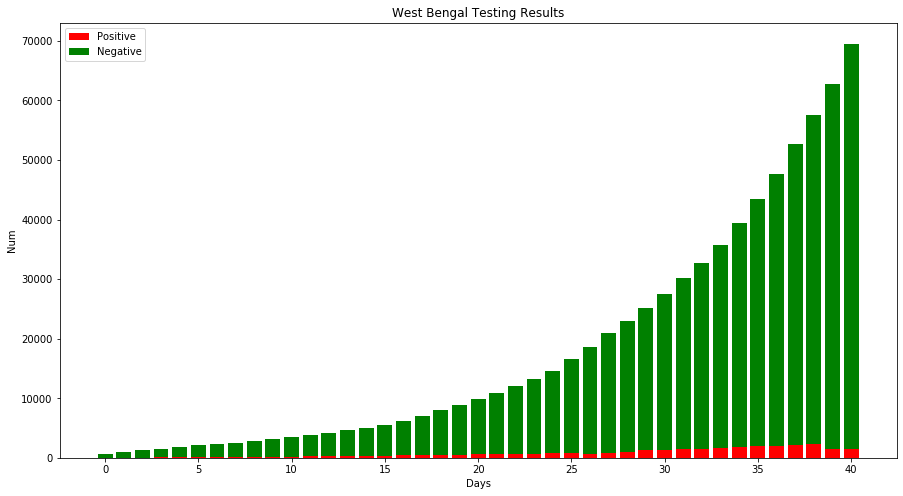

In [371]:
fig = plt.figure(figsize=(15,8))

ind = np.arange(len(west_bengal))    # the x locations for the groups
width = 0.8       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, west_bengal['Positive'], width, color='red')
p2 = plt.bar(ind, west_bengal['Negative'], width, color='green', bottom=west_bengal['Positive'])

plt.ylabel('Num')
plt.xlabel('Days')
plt.title('West Bengal Testing Results')
plt.legend((p1[0], p2[0]), ('Positive', 'Negative'))

plt.show()

Looks like at the very end, number of positive cases is decreasing.

Let's clean the patients data:

In [372]:
patient_df.head()

,Date_Announced,Age_Bracket,Gender,Detected_City,Detected_District,Detected_State,State_Code,Contracted_from_which Patient_Suspected,Notes,Nationality,Type_of_transmission,Source_1,Source_2,Source_3
0,2020-04-22,0.3,F,Mancheri,Malappuram,Kerala,KL,Unknown,"Details awaited, have been to admitted in hosp...",India,Unknown,https://twitter.com/PIBTvpm/status/12529408961...,https://www.facebook.com/malappuramcollector/p...,Unknown
1,2020-04-22,0.4,M,Unknown,Kalaburagi,Karnataka,KA,P13641,Contact of KA-P329,India,Unknown,https://t.me/Karnataka_KoViD19_Broadcast/2348,Unknown,Unknown
2,2020-05-01,1,M,Unknown,Davanagere,Karnataka,KA,P30609,Contact of KA-P556,India,Unknown,https://twitter.com/DHFWKA/status/125619607583...,Unknown,Unknown
3,2020-05-01,1,F,Unknown,Buxar,Bihar,BR,Unknown,Unknown,India,Unknown,https://twitter.com/sanjayjavin/status/1256144...,Unknown,Unknown
4,2020-04-02,1,F,Unknown,Chandigarh,Chandigarh,CH,Unknown,"Family contact of patients, IDs unknown",India,Local,https://twitter.com/ANI/status/124570290033410...,Unknown,Unknown


In [373]:
ages = patient_df['Age_Bracket']
ages.value_counts()

Unknown    30666
40           271
30           260
45           234
35           234
           ...  
84             1
0.4            1
89             1
2.5            1
0.3            1
Name: Age_Bracket, Length: 98, dtype: int64

Not very sure how the age bracket was measured :(

In [374]:
patient_df.groupby(['Contracted_from_which Patient_Suspected'])['Contracted_from_which Patient_Suspected'].nunique()

Contracted_from_which Patient_Suspected
C0                                                             1
E0                                                             1
E1                                                             1
Intern at AIIMS Rishikesh                                      1
KA-C0                                                          1
                                                              ..
https://twitter.com/ArogyaAndhra/status/1249575886665334791    1
https://twitter.com/ArogyaAndhra/status/1249575886665334792    1
https://twitter.com/ArogyaAndhra/status/1249575886665334793    1
https://twitter.com/ArogyaAndhra/status/1249575886665334794    1
https://twitter.com/ArogyaAndhra/status/1249575886665334795    1
Name: Contracted_from_which Patient_Suspected, Length: 287, dtype: int64

Contact trace also does not give very useful information. Some of these twitter links are invalidated.

Let's instead focus on the number of active cases:

In [358]:
## cumulative
recovered_true = recovered_df['Country'].sort_index().cumsum().to_numpy()
deceased_true = deceased_df['Country'].sort_index().cumsum().to_numpy()
confirmed_true = confirmed_df['Country'].sort_index().cumsum().to_numpy() - recovered_true - deceased_true

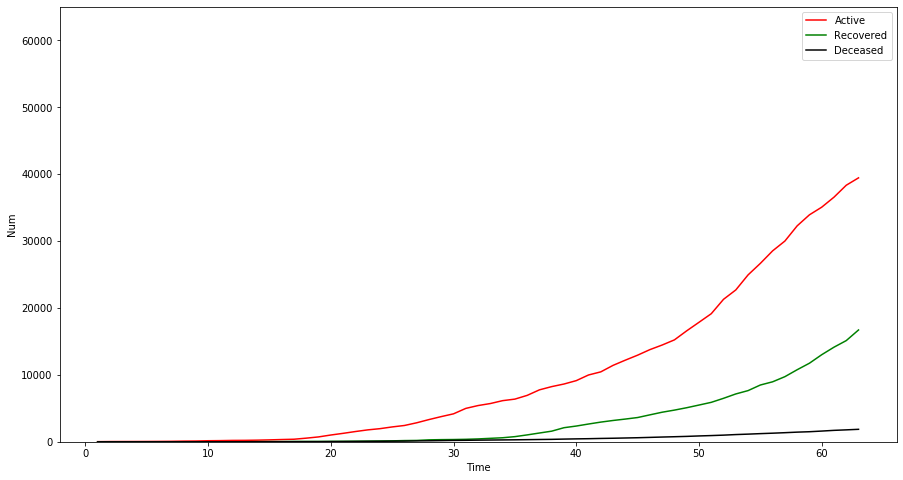

In [360]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)

t = len(recovered_true)
t = np.linspace(1, t, t)

ax.plot(t, confirmed_true, 'red', label = 'Active')
ax.plot(t, recovered_true, 'green', label = 'Recovered')
ax.plot(t, deceased_true, 'black', label = 'Deceased')
ax.set_xlabel('Time')
ax.set_ylabel('Num')
plt.ylim(0,65000)

legend = ax.legend()

Let's calculate the total population:

In [361]:
population_df.head()

,Sno,State / Union Territory,Population,Rural population,Urban population,Area,Density,Gender Ratio
0,1,Uttar Pradesh,199812341,155317278,44495063,"240,928 km2 (93,023 sq mi)","828/km2 (2,140/sq mi)",912
1,2,Maharashtra,112374333,61556074,50818259,"307,713 km2 (118,809 sq mi)",365/km2 (950/sq mi),929
2,3,Bihar,104099452,92341436,11758016,"94,163 km2 (36,357 sq mi)","1,102/km2 (2,850/sq mi)",918
3,4,West Bengal,91276115,62183113,29093002,"88,752 km2 (34,267 sq mi)","1,029/km2 (2,670/sq mi)",953
4,5,Madhya Pradesh,72626809,52557404,20069405,"308,245 km2 (119,014 sq mi)",236/km2 (610/sq mi),931


In [363]:
total_pop = sum(population_df['Population'])
print('total population is: {}'.format(1210568111))

total population is: 1210568111


## 3. Assumptions:

- Assume only transmission rate changes over time
- Assume data regarding the confirmed, recovered, and deceased is accurate
- Assume COVID-19 follows patterns of other viral diseases
- Assume the entire population has risks to be infected
- Assume a parametric form of the model (details below)

## 4. Model:
In this section, I will be constructing an SEIRD model.

**Compartments:**
- **S**: Susceptible
- **E**: Exposed
- **I**: Infected
- **R**: Recovered
- **D**: Deceased

**Parameters:**
<pre>
- N         : total population
- i         : incubation period
- sigma     : 1/i (incubation rate)
- D         : recovery period (average length of infection that leads to recover)
- gamma     : 1/D (recovery rate)
- b_vals    : beta transmission rates (number of people getting infected by one infected individual per day)
- m         : mortality rate (of infected individuals)
- d         : average length of infection that leads to death
- p         : 1/d (rate at which infected individuals die)
</pre>

**Explaination:**

SEIRD uses a system of ODEs **(Ordinary Differential Equations)** to model the spread of a virus by looking at different groups of individuals, including **susceptible, exposed, infected, recovered, and deceased**. The number of individuals in these compartments changes over unit time t, which is 'one day' in this case.

The general idea of the model is:

- **One** person was infected at the beginning
- Everyone in the population is **assumed** to enter the **Susceptible** group
- **One other** person is assumed to have **contacts with the infected**, entering the **Exposed** group
- The virus starts to spread
- Once an individual enter S group, they follow either **S -> E -> I -> R (recovered)** or **S -> E -> I -> D (deceased)**

I modeled beta (transmission rate) as a piecewise function that changes its value every 7 days, since **transmission rate is usually different at different stages of the virus.**

The 'model' function below takes in time steps (t), incubation period (i), recovery period (D), and b_vals (beta values), and returns number of people at S, E, I, R, D at corresponding time steps as a 2-d numpy array object.

In [205]:
def model(t, i, D, b_vals):

    N = total_pop
    sigma = 1.0/i
    gamma = 1.0/D
    m = 0.03
    d = 7.0
    p = 1.0/d

    def init_vals(S_0, E_0, I_0, R_0, D_0):
        y_0 = S_0, E_0, I_0, R_0, D_0
        return y_0

    def beta(t):
        return np.piecewise(t, [t <= 10, 
                                10 < t <= 20, 
                                20 < t <= 30,
                                30 < t <= 40,
                                40 < t <= 50, 
                                50 < t <= 60,
                                t > 60], b_vals).item()

    def seird(y, t, N, sigma, gamma, p, m):
        S, E, I, R, D = y
        dS_dt = -beta(t) * S * I / N
        dE_dt = beta(t) * S * I / N - sigma * E
        dI_dt = sigma * E - (1 - m) * gamma * I - p * m * I
        dR_dt = (1 - m) * gamma * I
        dD_dt = m * p * I
        return dS_dt, dE_dt, dI_dt, dR_dt, dD_dt
    
    y_0 = init_vals(N-2, 1, 1, 0, 0)
    t = np.linspace(1, t, t)
    S, E, I, R, D = odeint(seird, y_0, t, args=(N, sigma, gamma, p, m)).T
    
    return S, E, I, R, D

## 5. Optimization using Metropolis-Hastings Algorithm:

In this section, I will be using Metropolis-Hastings Algorithm (an MCMC based method) to estimate model parameters.

**Explaination:**
- Our goal is to estimate **i** (incubation period), **D** (recovery period), and **beta** (transmission rate)
- We first initialize some random (relatively reasonable) values as our initial guess
- We run the algorithm for 901 iterations (extra 1 because I want to compare the initial RMSE too)
- In each iteration, we do the following:
    - generate a new set of parameters from a normal distribution (mean is current set of parameters, standard deviation is assumed to be 0.01. Technically I have to tune the standard deviation, but for simplicity, I made an assumption)
    - compare the **RMSE** of **current** set of parameters and **new** set of parameters against the **true number of infected cases** (from dataset)
    - if RMSE of new parameters is **strictly lower** than the RMSE of current parameters, **update** current parameters as new parameters
    - otherwise, keep current parameters, and assign a very **small** probability of updating parameters (avoid stucking at **local minimum**)
- The parameters should converge to optimum values

In [221]:
i_cur = 8.0
beta_cur = [3,1,0.8,0.5,0.2,0.1,0.05]
D_cur = 8.0

n_iter = 901
t = len(confirmed_true)

i_vals = np.zeros((n_iter,1))
D_vals = np.zeros((n_iter,1))
rmse_vals = np.zeros((n_iter,1))

for step in range(n_iter):
    np.random.seed(step * 123141)
    i_next = abs(np.random.normal(i_cur, 0.01, 1))
    D_next = abs(np.random.normal(D_cur, 0.01, 1))
    beta_next = np.zeros((7,1))
    for i in range(7):
        beta_next[i] = abs(np.random.normal(beta_cur[i], 0.01, 1))

    I_cur_pred = model(t, i_cur, D_cur, beta_cur)[2]
    I_next_pred = model(t, i_next, D_next, beta_cur)[2]

    rmse_I_cur = mean_squared_error(I_cur_pred, confirmed_true) ** 0.5
    rmse_I_next = mean_squared_error(I_next_pred, confirmed_true) ** 0.5

    alpha = rmse_I_cur / rmse_I_next

    if (alpha > 1.0):
        i_cur = i_next
        beta_cur = beta_next
        D_cur = D_next
    else:
        decision = np.random.binomial(1, alpha / 1000, 1)
        if (decision == 1):
            i_cur = i_next
            beta_cur = beta_next
            D_cur = D_next

    i_vals[step] = i_cur
    D_vals[step] = D_cur
    rmse_vals[step] = rmse_I_cur

    if (step % 100 == 0):
        print ("iteration: {}, rmse: {}".format(step, rmse_I_cur))

iteration: 0, rmse: 6698.770267832703
iteration: 100, rmse: 12833.023480992366
iteration: 200, rmse: 9863.865308566552
iteration: 300, rmse: 5183.639186323052
iteration: 400, rmse: 7211.650029250117
iteration: 500, rmse: 5054.495792562995
iteration: 600, rmse: 3532.979206202735
iteration: 700, rmse: 2001.3437656847575
iteration: 800, rmse: 2840.446643387788
iteration: 900, rmse: 1264.6985384882134


## 6. Result

Here are the result of our optimization:

In [321]:
print("final values:")
print("i = {}, D = {},\n".format(i_cur, D_cur))
print("beta = {}\n".format(beta_cur))
print("resulted RMSE: {}".format(rmse_I_cur))

final values:
i = [10.02626035], D = [6.3661147],

beta = [[3.20525331]
 [0.85868239]
 [1.21677497]
 [0.65443459]
 [0.39656953]
 [0.36931794]
 [0.10015439]]

resulted RMSE: 1264.6985384882134


In [322]:
t = 150
S, E, I, R, D = model(t, i_cur, D_cur, beta_cur)
t = 150

## uncertainty
S_up, E_up, I_up, R_up, D_up = model(t, i_cur + 0.0196, D_cur + 0.0196, beta_cur + 0.0196)
I_up = I_up[np.arange(62,150)]
I_up[0] = confirmed_true[-1]
S_down, E_down, I_down, R_down, D_down = model(t, i_cur - 0.0196, D_cur - 0.0196, beta_cur - 0.0196)
I_down = I_down[np.arange(62, 150)]
I_down[0] = confirmed_true[-1]

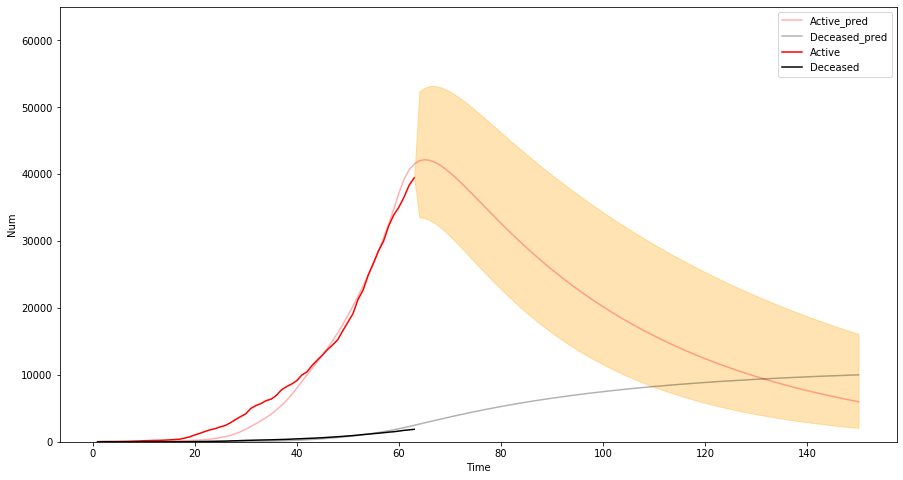

In [323]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)

t_error = np.linspace(63, t, t - 62)
t = np.linspace(1, t, t)

ax.plot(t, I, 'red', alpha=0.3, label = 'Active_pred')
#ax.plot(t, R, 'green', alpha=0.3, label = 'Recovered_pred')
ax.plot(t, D, 'black', alpha=0.3, label = 'Deceased_pred')
plt.fill_between(t_error, I_up, I_down, facecolor="orange", color='orange', alpha=0.3)
t = np.linspace(1,len(confirmed_true),len(confirmed_true))
ax.plot(t, confirmed_true, 'red', label = 'Active')
#ax.plot(t, recovered_true, 'green', label = 'Recovered')
ax.plot(t, deceased_true, 'black', label = 'Deceased')
ax.set_xlabel('Time')
ax.set_ylabel('Num')
plt.ylim(0,65000)

legend = ax.legend()

- Dark red curve: true active number of cases
- Light red curve: predicted active number of cases
- Black curve: true number of deaths
- Grey curve: predicted number of deaths
- Orange area: 95% CI (prediction interval)

## 7. Comments

Now, let's talk about our result.

The **RMSE** we got eventually was 1264.6985, and if we average it for the total duration, we get **20.08** per day.

Forecasting viruses like COVID-19 is very different than the usual training/testing/validating approaches in machine learning because the data we got is **extremely** limited. In my model, I used all the confirmed, recovered, and deceased data in the training process.

However, one very huge limitation is that the training data has very large uncertainties. For example, different countries use very different ways of counting number of deaths. In a death certificate, they usually list several causes of death, and because COVID-19 could invoke other underlying health issues, a lot of the deaths were not counted as directly caused by COVID-19.

In addition, some infected people were not counted as infected because of the limited testing capacities.

In fact, one of the biggest criticisms faced by many leading COVID-19 projection models such as IHME's (Institue for Health Metrics and Evaluation) model is that they do not give a detailed explaination of where their **margin of error** came from. That's why I used the training **RMSE** as a evaluation metric in this case.

The 95% CI (prediction interval) is calculated based on the overall effects of point estimates (incubation period, recovery period, and transmission rate). 

Let's plot the paths for incubation and recovery period:

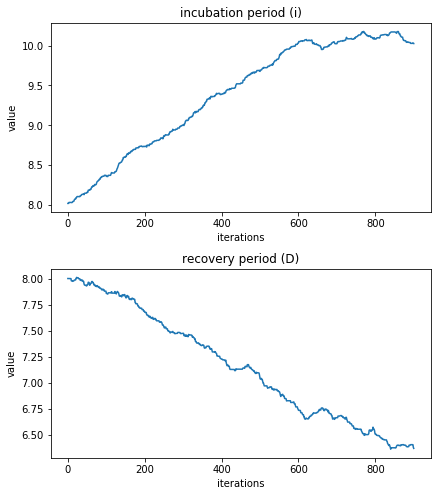

In [245]:
fig = plt.figure(figsize=(15,8))

plt.subplot(2, 2, 1)
plt.subplots_adjust(hspace=0.3)
plt.title('incubation period (i)')
plt.xlabel('iterations')
plt.ylabel('value')
plt.plot(i_vals)

plt.subplot(2, 2, 3)
plt.title('recovery period (D)')
plt.xlabel('iterations')
plt.ylabel('value')
plt.plot(D_vals)

plt.show()

I only ran a few iterations after the 'burn-in' period since I am running this algorithm on my laptop from 5 years ago :( Ideally, the algorithm has to run many more iterations to obtain more precise results.

## 8. Answers to Questions

### Q1: Estimate at which point can one expect to see the peak in number of COVID-19 cases in the following states: Maharashtra, Delhi, Tamil Nadu, Gujarat?

**21-May-2020 ± 6 days (95% CI, calculations below)**

### Q2: By which date will the states listed above have less than 100 COVID-19 cases?

**14-March-2021 (assuming no second wave, full capacity testing kits, no seasonal impacts)**

### Q3: Based on the data we’ve provided - what would be the number of cases in the aforementioned states by June 30th?

**15828 active cases**

### Q4: How has the growth and the spread of the virus looked across the country since the first case?

Please see the plot of transmission rate (beta) value over time:

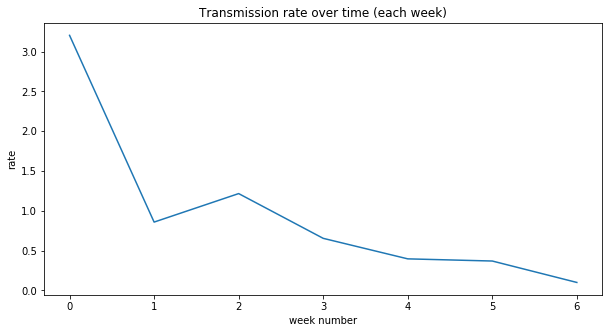

In [299]:
fig = plt.figure(figsize=(10,5))

plt.plot(beta_cur)
plt.title('Transmission rate over time (each week)')
plt.ylabel('rate')
plt.xlabel('week number')
plt.show()

### Calculations:

In [306]:
peak = np.argmax(I)
date = '21-May-2020'
error = np.argmax(I_up)
print("Days till peak since first day of record: {}, error: {}, date = {}".format(peak, error, date))

Days till peak since first day of record: 64, error: 5, date = 21-May-2020


In [307]:
t = 400
S, E, I, R, D = model(t, i_cur, D_cur, beta_cur)
res = t - sum(I < 100)
date = '14-March-2021'
print('Days till less than 100 active cases: {}, date: {}'.format(res, date))

Days till less than 100 active cases: 303, date: 14-March-2021


In [308]:
d = 63 + 46
res = I[d]
print('Number of active cases on June 30th: {}'.format(np.round(res)))

Number of active cases on June 30th: 15828.0


## 9. Disclaimer:

### This notebook is intended for DubsTech's 2020 Datathon submission only. Numbers predicted by this model should not be used for any other purpose.